# MSE_test and MSE_train as function of model complexity

In [1]:
%matplotlib inline
%load_ext autoreload 
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np

Seed value:  0
Seed value:  1
Seed value:  2
Seed value:  3
Seed value:  4
Seed value:  5
Seed value:  6
Seed value:  7
Seed value:  8
Seed value:  9
Seed value:  10
Seed value:  11


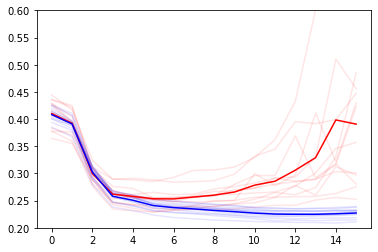

In [3]:
from franke_function import FrankeFunction as Fr
from regression import OLS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0, 1, 50) # lite: 50, stort: 500
y = np.linspace(0, 1, 50)
x, y = np.meshgrid(x, y)

poly = 16
MSE_test_list = []
MSE_train_list = []

for n in range(12): #loop thru 15 first seed values
    print("Seed value: ", str(n))
    np.random.seed(n) # Results is highly sensitive to seed choice, for thru different seed values? 
    noise = np.random.randn(x.shape[0], x.shape[1])
    z = Fr(x, y) + noise*np.var(Fr(x, y))*2
    
    scaler = StandardScaler() 
    x_cent = scaler.fit_transform(x.reshape(-1, 1)) #could be done outside loop, here for readability
    y_cent = scaler.fit_transform(y.reshape(-1, 1)) #could be done outside loop, here for readability
    z_cent = scaler.fit_transform(z.reshape(-1, 1))

    xy_cent_train, xy_cent_test, z_cent_train, z_cent_test = train_test_split(np.hstack([x_cent, y_cent]),
                                                                          z_cent, test_size=0.2)
    MSE_test = []
    MSE_train = []
    for poly_deg in range(1, poly + 1):
        model = OLS(xy_cent_train[:, 0].ravel(), xy_cent_train[:, 1].ravel(), z_cent_train.ravel(), poly_deg)
    
        MSE_test.append(model.MSE(xy_cent_test[:, 0], xy_cent_test[:, 1], z_cent_test.ravel()))
        MSE_train.append(model.MSE(xy_cent_train[:, 0], xy_cent_train[:, 1], z_cent_train.ravel())) # orig model.
    
    plt.plot(MSE_test, 'r', alpha=0.1) # test settet gir alltid litt verre estimat ser det ut til
    plt.plot(MSE_train, 'b', alpha=0.1) 
    
    MSE_test_list.append(MSE_test) # sore all values for averaging
    MSE_train_list.append(MSE_train)
    
MSE_test_list = np.array(MSE_test_list)
MSE_train_list = np.array(MSE_train_list)

test_pol_avrg = np.mean(MSE_test_list, axis=0)
train_pol_avrg = np.mean(MSE_train_list, axis=0)

plt.plot(test_pol_avrg, 'r')
plt.plot(train_pol_avrg, 'b')

plt.ylim(0.2, 0.6)
plt.show()
# Observasjonar: 
# Med høyoppløslig grid må eg ha mer støy for at bias variance tradeoff skal oppdages
# Dette kan ha med at med høyoppløslig grid så tvinges funksjonen i større grad å forholde seg til F(x, y)
# , ikkje til støy. (må svinge mykje for å nå alle punkter når dei ligg tettere)Ein kan sjå for seg ein scatter 
#med tett i tett med punkter eller spredde punkter. Dersom  
# pukta ligg tett treng ein meir støy for at polynomet skal over-tilpasse seg. 

# I oppgava: Utled bias variance relation!

In [4]:
(1/(Fr(x, y).size - 1)) * np.sum((Fr(x, y) - np.mean(Fr(x, y)))**2)

0.08217810579830617

# Bootstrap - Reconstructing real world variance

In [3]:
from franke_function import FrankeFunction as Fr
from regression import OLS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0, 1, 50) # lite: 50, stort: 500
y = np.linspace(0, 1, 50)
x, y = np.meshgrid(x, y)

poly = 15
n_bootstraps = 20
MSE_test_list = [] 
MSE_train_list = []
predict_train_list = []
betas_list = []

noise = np.random.randn(x.shape[0], x.shape[1])
z = Fr(x, y) + noise*0.18 #0.18 # multiply with degree of noice. 
    
scaler = StandardScaler() # Scaling does not affect OLS, but it does affect bootstrap
x_cent = scaler.fit_transform(x.reshape(-1, 1))  #scaler.fit_transform(x.reshape(-1, 1)) 
y_cent = scaler.fit_transform(y.reshape(-1, 1))  #scaler.fit_transform(y.reshape(-1, 1)) 
z_cent = scaler.fit_transform(z.reshape(-1, 1)) #scaler.fit_transform(z.reshape(-1, 1))

xy_cent_train, xy_cent_test, z_cent_train, z_cent_test = train_test_split(np.hstack([x_cent, y_cent]),
                                                                          z_cent, test_size=0.2)

for n in range(n_bootstraps): 
    print("Bootstrap number: " + str(n+1) + '/' + str(n_bootstraps))
    MSE_test = []
    MSE_train = []
    predict_train = []
    beta_poly = []
    
    #draw n samples from train set
    n = z_cent_train.size 
    samples_nr = np.random.randint(0,n,n)
    xy_samp = xy_cent_train[samples_nr, :]
    z_samp = z_cent_train[samples_nr, :]
    
    # polynomial fit to bootstrap samples
    for poly_deg in range(1, poly + 1):
        # fit model to bootstrap data
        model = OLS(xy_samp[:, 0].ravel(), xy_samp[:, 1].ravel(), z_samp.ravel(), poly_deg)
        
        #calculate interesting numbers
        MSE_test.append(model.MSE(xy_cent_test[:, 0], xy_cent_test[:, 1], z_cent_test.ravel()))
        MSE_train.append(model.MSE(xy_samp[:, 0], xy_samp[:, 1], z_samp.ravel())) # orig model.
        beta_poly.append(model.beta_OLS.ravel()) #transposing to get rid of list in list problem
        predict_train.append(model.predict(xy_samp[:, 0], xy_samp[:, 1]).ravel())
    
    MSE_test_list.append(MSE_test) # sore all values for averaging
    MSE_train_list.append(MSE_train)
    predict_train_list.append(predict_train)
    betas_list.append(beta_poly) # store all beta values for estimation of confidence intervals
    
MSE_test_list = np.array(MSE_test_list)
MSE_train_list = np.array(MSE_train_list)

#study average values
test_pol_avrg = np.mean(MSE_test_list, axis=0)
train_pol_avrg = np.mean(MSE_train_list, axis=0)

test_var = np.var(MSE_test_list, axis=0) #sqrt(variance), for hvert polynom, beregn variansen
train_var = np.var(MSE_train_list, axis=0)

Bootstrap number: 1/20
Bootstrap number: 2/20
Bootstrap number: 3/20
Bootstrap number: 4/20
Bootstrap number: 5/20
Bootstrap number: 6/20
Bootstrap number: 7/20
Bootstrap number: 8/20
Bootstrap number: 9/20
Bootstrap number: 10/20
Bootstrap number: 11/20
Bootstrap number: 12/20
Bootstrap number: 13/20
Bootstrap number: 14/20
Bootstrap number: 15/20
Bootstrap number: 16/20
Bootstrap number: 17/20
Bootstrap number: 18/20
Bootstrap number: 19/20
Bootstrap number: 20/20


In [4]:
# sort predicted train values to polynomial degree, its slightly more intuitive for me..
poly_list = [[] for _ in range(len(predict_train_list[0]))] #prepare list of polynomial
for bootstrap_nr in range(len(predict_train_list)):
    for poly_degree in range(len(predict_train_list[bootstrap_nr])):
        poly_list[poly_degree].append(predict_train_list[bootstrap_nr][poly_degree])

mean_var_z = []
for pol in poly_list:
    pol = np.array(pol)
    var_points = np.var(pol, axis=1, keepdims=True) # var of 20 bootstraps from n points
    mean_var_z.append(np.mean(var_points))    

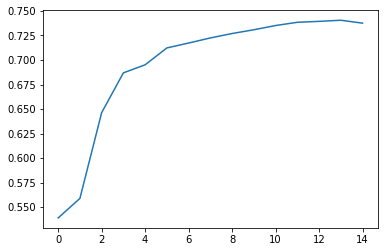

In [5]:
plt.plot(mean_var_z)

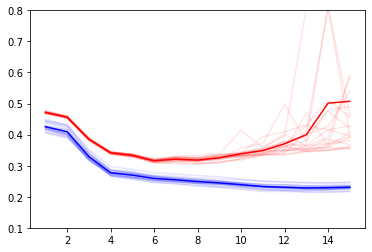

In [14]:
for i in range(len(MSE_test_list)):
    plt.plot(range(1, len(MSE_test)+1), MSE_test_list[i], 'r', alpha=0.1) 
    plt.plot(range(1, len(MSE_test)+1), MSE_train_list[i], 'b', alpha=0.1) 

plt.plot(range(1, len(MSE_test)+1), test_pol_avrg, 'r')
plt.plot(range(1, len(MSE_train)+1), train_pol_avrg, 'b')
#plt.plot(range(1, len(variance_avrg)+1), variance_avrg, 'g')

plt.ylim(0.1, 0.8)
plt.show()
# Observasjonar: 
# I Plottet under: Trekker ulike samples fra datasettet (med tilbakelegging) og predikerer optimal fit for ulike 
# polynomer med grad p. 

# I eksempelet over brukte eg ulike seed-verdier for å lage ulike utfall av støy. 
# I dette eksempelet viser me at det er mulig å modellere usikkerheit med  

# Study irreducible noise

In [39]:
noise = np.random.randn(x.shape[0], x.shape[1]) # normalfordelt støy. 
np.var(Fr(x, y)) # variansen til Fr, kor mykje den er over og under sitt gjennomsnitt. 
# eg skalerer jo data? 
print('Varians lagt til data: ' + str(np.var(noise*np.var(Fr(x, y))*2))) #støy som legges til modellen. Irreducible.
print('Tilsvarer std avvik: ' + str(np.sqrt(np.var(noise*np.var(Fr(x, y))*2))))
# beregnes som gjennomsnittlig (modell - virkelighet) ** 2 
print('Varians i franke: ' + str(np.var(Fr(x, y))))

Varians lagt til data: 0.025513647071256453
Tilsvarer std avvik: 0.15972991914871945
Varians i franke: 0.08214523455598685


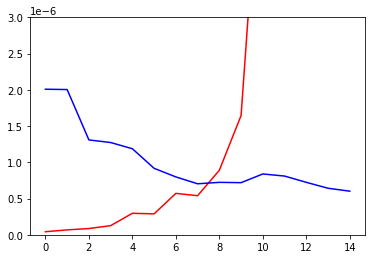

Mean train std: 1.0175336339480104e-06


In [4]:
plt.plot(test_var, 'r')
plt.plot(train_var, 'b')
plt.ylim(0, 0.000003)
plt.show()
print("Mean train std: " + str(np.mean(train_var)))
# Observasjon: gjennomsnittlig avvik i MSE for treningsdata ser ut til å flate ut. 
# Dette setemmer bra overens med det vi observerer i plottet over. Den flater ut omtrent der feilen i test ser ut
# til å begynne å vokse også. 

In [15]:
import itertools
# studerer spredning i estimater på en ekstremt krevende måte... 
poly_list = [[] for _ in range(len(Predict_train_list[0]))]
for bootstrap_nr in range(len(Predict_train_list)):
    for poly_degree_nr in range(len(Predict_train_list[bootstrap_nr])):
        poly_list[poly_degree_nr].append(list(
            itertools.chain(*Predict_train_list[bootstrap_nr][poly_degree_nr])))

# poly_list inneholder nå alle forsøk på å gjette y i alle punkter, sortert etter polynom-grad.

        
mean_z = []
var_z = []
for pol in poly_list:
    pol = np.array(pol)
    pol = pol.T
    mean_points = np.mean(pol, axis=1) # mean of 20 bootstraps from 2000 points
    var_points = np.var(pol, axis=1) # var of 20 bootstraps from 2000 points
    
    mean_z.append(np.mean(mean_points)) # gjennomsnittlig gjetta z-verdi for hele feltet
    var_z.append(np.mean(var_points)) # gjennomsnittlig spredning i z-verdi gjetning
    


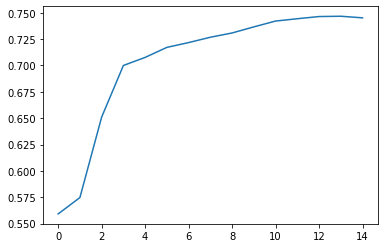

In [16]:
plt.plot(var_z)

In [ ]:
# Observasjon, nærmer seg variansen til franke funksjonen?

# Study and compare beta with results from ex1

In [7]:
# first we sort stored beta values so we can access them by polynom number first, its more intuitive... 
betas_list
poly_list = [[] for _ in range(len(betas_list[0]))] # same numbers, sorted on poly degree
for bootstrap_nr in range(len(betas_list)): # for thru all bootstraps
    for poly_degree in range(len(betas_list[bootstrap_nr])): # for tru all poly degrees in each bootstrap
        poly_list[poly_degree].append(betas_list[bootstrap_nr][poly_degree]) # sort betas
        
mean_beta = []
var_beta = []

for poly_degree in range(len(poly_list)): # for each polynomial degree, calculate beta mean and beta variance
    betas_poly = np.array(poly_list[poly_degree]) #easier to work with array here
    mean_beta.append(np.mean(betas_poly, axis=0)) # mean for b_i of n bootstraps
    var_beta.append(np.var(betas_poly, axis=0)) # spread of that beta

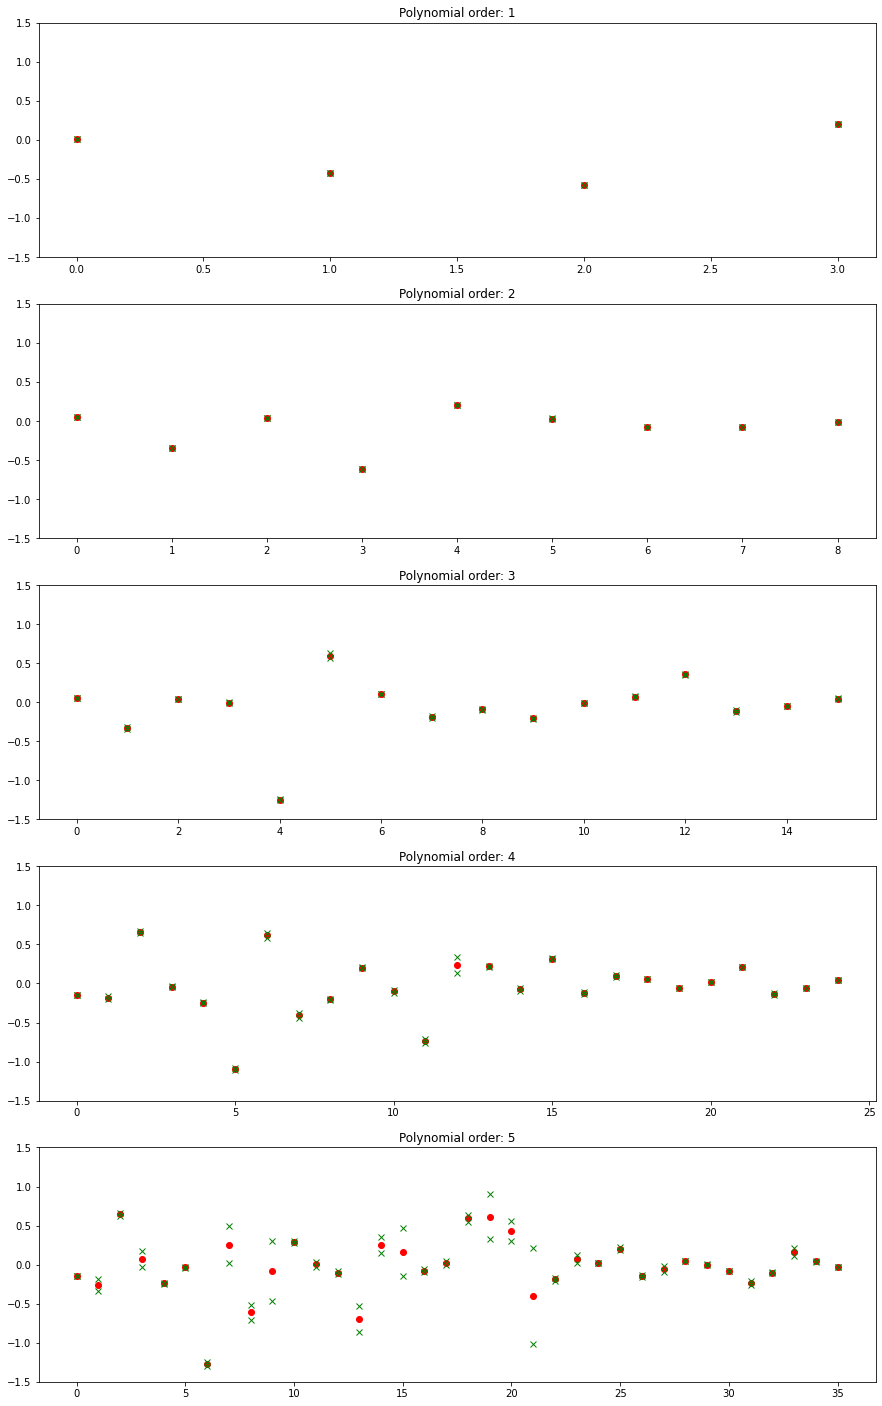

In [8]:
import matplotlib.pyplot as plt
n_polynom = 5 # plot polynoms up to n_polynom order
sigma = 2 # plot two sigma uncertainty
fig, axs = plt.subplots(n_polynom, 1, figsize=(15, 25), facecolor='w', edgecolor='k')
axs = axs.ravel()

sigma = 3
for polynom_nr in range(n_polynom):
    for beta_i in range(len(mean_beta[polynom_nr])): # plot beta_i mean and its spread
        axs[polynom_nr].plot(beta_i, mean_beta[polynom_nr][beta_i], 'ro') #plot middle beta
        axs[polynom_nr].plot(beta_i, mean_beta[polynom_nr][beta_i] + sigma*var_beta[polynom_nr][beta_i], 'gx') 
        axs[polynom_nr].plot(beta_i, mean_beta[polynom_nr][beta_i] - sigma*var_beta[polynom_nr][beta_i], 'gx') 
    axs[polynom_nr].set_title('Polynomial order: ' + str(polynom_nr + 1))
    axs[polynom_nr].set_ylim([-1.5, 1.5])